In this post, we’ll focus on customer segmentation and provide practical examples using k-means algorithm.


  Companies serve customers with unique interests, having different sensitivities to price, product preferences and requirements which cannot be satisfied by using a single one-size-fits-all marketing campaign. As a company you cannot also personalize marketing campaigns for each customer, instead, marketers use cluster analysis to discover pattern within the customers (customers data) and partition them into distinct homogenous segments so that observations within each segment are quite similar to each other, while observations in different segments are quite different from each other. This is perceived as an important business opportunity because by identifying subgroups of people who might be more receptive to a particular form of advertising, or more likely to purchase a particular product, this allow a company to maximise the use of it limited resources. Since we are writing about customers segmentation, what Is Customer Segmentation?



###  What Is Customer Segmentation?
**Customers segmentation** is the process of partitioning a target customers  into segments where customers within each segment are similar and collectively different from customers in other segments. The general goal of customer segmentation is to identify subgroups of customers with common characteristics and wants. Customer segmentation assumes that different segments of customer  require different marketing campaigns and a company might segment their customers based on  demographic, psychographic, geographic, and behavioral.


## Why is customer segmentation important?

Customers have different sensitivities to price, product preferences and requirements. Markets are also saturated with attractive products and services, of which many are in direct competition with your product, services and marketing offerings, so by identifying the differences and similarities between potential customer segments, and with a deep understanding of each segment, a marketer can make better strategic choices about opportunities, develop more competitive and attractive offerings tailor to the specific requirements of each segment to better satisfy their wants that aim to outweigh the bundle of benefits provided by your competitors. This make marketing campaigns more effective and provide a significant boost to the company and also improve customer service.


There are many clustering techniques  (unsupervised machine learning algorithms) that can help companies segment their customers but in this post I will focus on a very commonly used technique known as **K-means clustering**. Before diving into K-Means clustering let first load the mall customers data that will be used in this post and preprocess it. 

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
mall_data=pd.read_csv("./data/Mall_Customers.csv")
mall_data.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


The data contain attributes such as age and gender of the customers, their estimated annual income (Annual Income (k$)) and the the spending score (Spending Score (1-100)) which denotes the amount of shopping the customer has done at the mall (a higher score means a higher spending ).

In [3]:
mall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


With the data information provided above we can see that the mall data contain 5 attributes and 200 samples (customers) with no missing values

Let rename the attributes **Annual Income (k$)** to **Income** and **Spending Score (1-100)** to **Spending_Score**

In [4]:
mall_data.rename(columns={'Annual Income (k$)':'Income',
                          'Spending Score (1-100)':'Spending_Score'},
                             inplace=True)

In [5]:
mall_data.columns

Index(['CustomerID', 'Gender', 'Age', 'Income', 'Spending_Score'], dtype='object')

### Selecting Clustering Variables
There are multiple ways to segment customers and because of its exploratory nature, there is always the question of whether the cluster analysis is producing the correct segmentation scheme and is the result useful for targeting your audience. To make the segmentation useful it is important to first define the variables that form the basis of the homogeneous groups of customers because these variables directs the nature of the groups formed and provide insights into the grouped formed. In this post I will segments customers based on their income level and spending scores regardless of
the customer gender and age so that we can have different marketing strategy for customers with high income and low spending scores, those with medium income and spending scores versus those with low income and high spending scores.

In [6]:
mall_data_1=mall_data.copy()

In [7]:
selected_cols=['Income', 'Spending_Score']
mall_data_1[selected_cols].head(3)


,Income,Spending_Score
0,15,39
1,15,81
2,16,6


Let visualize the relationship between income and spending score

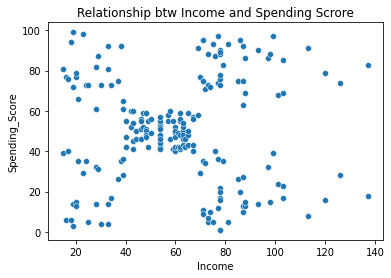

In [8]:
sns.scatterplot(x=mall_data_1.Income,y=mall_data_1.Spending_Score)
plt.title("Relationship btw Income and Spending Scrore")
plt.show()

From the above graph the seems to be no correlation (relationship) between income and spending score . It also seems to have 5 natural groups

In [9]:
mall_data_1[selected_cols].corr()

,Income,Spending_Score
Income,1.000000,0.009903
Spending_Score,0.009903,1.000000


In [10]:
print("Min income: "+ str(mall_data_1[selected_cols].Income.min()))
print("Max income: "+ str(mall_data_1.Income.max()))
print("Min spending-score: "+ str(mall_data_1.Spending_Score.min()))
print("Max spending-score: "+ str(mall_data_1.Spending_Score.max()))

Min income: 15
Max income: 137
Min spending-score: 1
Max spending-score: 99


## Standardizing  Customer Data
From the minimum and maximum values for Income and Spending score above we can see that the 
two segmentation variables are measured on different scale. Since K-Means is distance-based methods of segment extraction, the range of values of a segmentation variable affects its relative influence on the clustering result so to balance the influence of the segmentation variables on the segmentation results, the segmentation variables are standardized to puts them on a common scale. I will standardize the mall data using z-scoring which is given as

$$z=\frac{x_{i}-\bar{x}}{s} $$

$s=standard \ deviation$ 

In [11]:
z_score=StandardScaler()
mall_data_1[selected_cols]=z_score.fit_transform(mall_data_1[selected_cols])

In [12]:
mall_data_1.head(3)

,CustomerID,Gender,Age,Income,Spending_Score
0,1,Male,19,-1.738999,-0.434801
1,2,Male,21,-1.738999,1.195704
2,3,Female,20,-1.700830,-1.715913


let now dive into K-means clustering 

# K-Means Clustering

K-means clustering is an approach for partitioning a dataset into a set of k $(k<n )$  distinct clusters where k represent the number of clusters and it's pre-specified by the analyst.
Using K-Means algorithmn each observation is assigned to one and only one cluster and can be characterized by a manyto-one mapping $k=C(i)$ that assigns the $i$th observation to the $k$th cluster with the goal of minimizing the differences within each cluster while maximizing the differences between clusters.

Partitioning customers into subgroups requires a method for computing the dissimilarities or similarities between customers. The choice of similarities (distance) measures is a critical step in clustering as it defines what it means for two or more observations (customers) to be similar or different and also influences the clustering result. 
There are several different clustering criteria (distance measure) such as Manhattan and correlation-based distances but in this post squared Euclidean distance is chosen as the dissimilarity measure because with squared euclidean distance, customers with high values of variables tend to cluster together and those with low values of variables also tend to be cluster together and is given by

$$d(x_{i}, x_{i′}) =\sum_{j=1}^{p} \lgroup x_{ij} -x_{i'j} \rgroup ^{2}=|| x_{i} -x_{i'}||^{2}$$


The basic idea behind k-means clustering consists of defining clusters such that the 

total intra-cluster variation known as total within-cluster sum of square (WSS) which is a measure  of the amount by which the observations within a cluster differ from each other is minimized. The total within-cluster variation  is defined as

$$WSS= \sum_{i \in k}\sum_{j=1}^{p} \lgroup x_{ij} -\mu_{kj} \rgroup ^{2} $$

where k is the cluster, $x_{ij}$ is the value of the $j$th variable for the $i$th observation, $µ_{kj}$ is the is the centroid for the $k$th cluster, and p is the number of variables.

## Conceptually, the k-means algorithm is as follows:

1. Specify the number of clusters (K) to be created (by the analyst)

2. Randomly initialize k data points as the initial cluster centers (centroids).

3. Assigns each observation to their closest centroid, based on the Euclidean distance between the observation and the centroid. Each of these centroids represents a cluster.

4. Recalculate the cluster center (new centroids) as the average of its assigned data points

5. Compute the distance between each observation and the new centroids and assign the data point to its closest centroid (new centroids).

6. Iteratively minimize the total within sum of square. That is, iterate steps 4 and 5 until the cluster assignments stop changing (The centroids do not move significantly so observations aren’t reassigned new cluster) or or a maximum number of iterations is reached .



## Choosing the Right Number Of Clusters

Determining the optimal number of clusters is a fundamental issue in partitioning clustering.  Features used play an important role in defining similarities between clusters(customers). We usually do not know the optimal number of clusters, so there is a need to understand the different ways in choosing the optimal number of clusters. Decisions on the number of clusters can be subjective and depends on the method used for measuring similarities and the features used for partitioning. Choosing k can be subjective so if you have prior domain knowledge as to how many clusters should theoretically be present in a dataset, then you can use this knowledge to guide your selection. There are several approaches for determining the optimal number of clusters including visual inspection, silhouette score, elbow method, gap statistic method and many more  but in this post I will only look at the elbow method. These quantitative measures only tell how well that number of clusters fits the data. They do not tell how useful these clusters are for business. Since, it is the  business analyst that will interpret and act on these clusters, they have to understand the nature of the clusters and what each cluster cares about. So no matter how good these clusters are statistically, they are useless if they are not actionable by the business.





### Elbow Method

The basic idea behind k-means clustering consists of defining clusters such that thEtotal within-cluster sum of square (WSS) is minimized. 

Using Elbow method, the method looks at the total WSS as a function of the number of clusters. The total WSS will decreases as the number of clusters increases, because each cluster will be smaller and tighter. In this process the hope is that the rate at which the WSS decreases will slow down for k beyond the optimal number of clusters. In other words, the graph of WSS versus k should flatten out beyond the optimal k, so the optimal k will be at the **elbo** of the graph.

The optimal number of clusters can be defined as follow:


1. Compute k-means clustering for different values of k ,for instance, by varying k from 1 to 10 clusters.
2. For each k, calculate the total within-cluster sum of square (wss).
3. Plot the curve of wss according to the number of clusters k.
4. The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters

Let’s try calculating WSS for up to 15 clusters

C:\Users\arize\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\arize\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\arize\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\arize\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

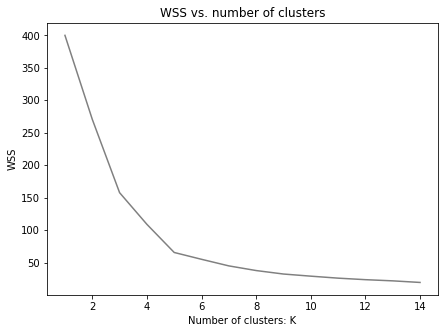

In [13]:
wss=[]
K= range(1,15)
for k in K:
    km=KMeans(n_clusters=k,random_state=42)
    km=km.fit(mall_data_1[selected_cols])
    wss.append(km.inertia_)
    
    
plt.figure(figsize=[7,5])
plt.plot(range(1,15), wss, color='gray')
plt.title("WSS vs. number of clusters")
plt.xlabel("Number of clusters: K")
plt.ylabel('WSS')
plt.show()

When we look at the graph the peak of the bend,  occurs at around the 5th cluster, indicating that this is the ideal number of clusters to fit for with the K-means algorithm. The code below instantiate a KMeans model with 5 number of clusters (n_clusters).

In [14]:
kmeans_model=KMeans(n_clusters=5,random_state=42)

Next, fit the model on the data using the selected columns named selected_cols. 

In [15]:
kmeans_model.fit(mall_data_1[selected_cols])

C:\Users\arize\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

Using the predict method of the k-means model, the code below assign to each customer a cluster with the cluster variable named as Cluster.

In [16]:
mall_data_1['Cluster']=kmeans_model.predict(mall_data_1[selected_cols])

Let Now visualize the data points and their assigned cluster by using different shape and color for each cluster.

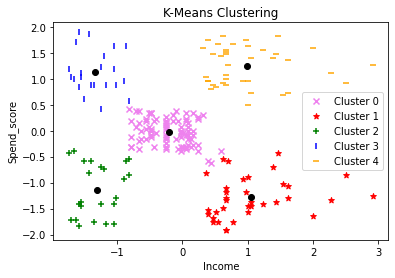

In [17]:
markers = ['x', '*', '+', '|', '_']
colors=['violet','red','green','blue','orange']
centroid=kmeans_model.cluster_centers_

for cluster in range(5):
    temp = mall_data_1[mall_data_1.Cluster == cluster]
    plt.scatter(temp.Income, temp.Spending_Score, marker=markers[cluster], 
                color = colors[cluster], label="Cluster "+str(cluster))
    plt.scatter(centroid[cluster][0],centroid[cluster][1],color = 'black')
  
plt.xlabel('Income')
plt.title("K-Means Clustering")
plt.ylabel('Spend_score')
plt.legend()

plt.show()

Looking at the scatter plot above with clusters represented by different shapes and colors, 
the k-means algorithm did a great job of identifying the natural grouping within the data .

## Understanding and Describing the Clusters

As a marketing analysts, you need to have a clear understanding of each segments so that you can
explaina to the various stakeholders in the business what each cluster (segment) means from a business perspective since they are usually the decision makers. To understand the clusters, one simple approach is to study the various characteristics of the customers based on the relevant features used for clustering. To understand the characteristics of the clusters, we will analyze the features in the original  mall dataset (mall_data)  which does not contain scaled features by adding their predicted clusters to see how Income and Spending_Score varies across the clusters. 

the code below add customers predicted clusters to the original mall dataset:


In [18]:
mall_data["Cluster"]=mall_data_1.Cluster

To see how Income and Spending_Score varies across the segments, let group the dataset by Cluster and plot the mean value of each cluster using the code below

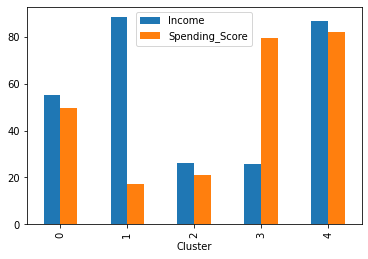

In [19]:
mall_data.groupby('Cluster')[['Income','Spending_Score']].mean().plot.bar()
plt.show()

Let also sample 10 customers with their predicted clusters

In [20]:
mall_data.sample(10)

,CustomerID,Gender,Age,Income,Spending_Score,Cluster
24,25,Female,54,28,14,2
111,112,Female,19,63,54,0
124,125,Female,23,70,29,1
16,17,Female,35,21,35,2
138,139,Male,19,74,10,1
92,93,Male,48,60,49,0
130,131,Male,47,71,9,1
174,175,Female,52,88,13,1
11,12,Female,35,19,99,3
183,184,Female,29,98,88,4


From the above graph and table we can describe the clusters as:

- **Cluster 0**: Moderate spenders with moderate-income 
- **Cluster 1**: Low spenders with high-income
- **Cluster 2**: Low spenders with low-income 
- **Cluster 3**: High spenders with low-income 
- **Cluster 4**: High spenders with high-income 

With these clusters, the business can decide to focus on customers in cluster 0,3,4 since these clusters have high spending scores which provide high revenues to the business.